# Cluster Photos

This notebook leverages learned features and out-of-the-box clustering techniques to cluster photos with the intent of finding a representative sample.

## Instantiate Encoder

Let's create our encoders and do preliminary work to process our images.

In [28]:
import torch

from photo_encode.encoder import FaissIndexImageEncoder
from transformers import AutoImageProcessor, AutoModel, ViTImageProcessor, ViTModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# First embedding model: dinov2
processor_dino = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
processor_kwargs_dino = {
    "return_tensors" : "pt"
}
dinov2_hf = AutoModel.from_pretrained('facebook/dinov2-large')
dinov2 = FaissIndexImageEncoder(
    dinov2_hf, 
    index_file_out="./data/test_photos_dinov2.db", 
).eval().to(device)

# Second embedding model: ViT
processor_vit = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
processor_kwargs_vit = {
    "return_tensors" : "pt"
}
vit_hf = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
vit = FaissIndexImageEncoder(vit_hf, index_file_out="./data/test_photos_vit.db").eval().to(device)

## Create the Embeddings

Loop over the data with different models and aggregration functions to create our embeddings.

In [31]:
import torch

from tqdm import tqdm

from photo_encode.utils import image_batch_from_folder_generator
from torchvision.transforms import Resize, Compose

# Directory with photos
photo_directory = "./data/test_photos"

# Batch size
batch_size = 8

# Mean aggregation
def dinov2_mean_aggregate(x):
    embeddings = x.last_hidden_state
    return embeddings.mean(axis=1)

def vit_mean_aggregate(x):
    embeddings = x.last_hidden_state
    return embeddings.mean(axis=1)
    
# Walk over the photo directory
with torch.no_grad():
    # For dinov2, we need to override the stack function as the batch collator
    for x, files in tqdm(
        image_batch_from_folder_generator(photo_directory, processor_dino, processor_kwargs_dino, batch_size, collate=lambda x: x)
    ):
        pixel_values = torch.stack(tuple([y["pixel_values"][0] for y in x]))
        dino_batch = {
            "pixel_values" : pixel_values.to(device)
        }
        embeddings = dinov2(dino_batch, files, dinov2_mean_aggregate)

    # For ViT
    for x, files in tqdm(
        image_batch_from_folder_generator(photo_directory, processor_vit, processor_kwargs_vit, batch_size, collate=lambda x: x)
    ):
        pixel_values = torch.stack(tuple([y["pixel_values"][0] for y in x]))
        vit_batch = {
            "pixel_values" : pixel_values.to(device)
        }
        embeddings = vit(vit_batch, files, vit_mean_aggregate)



85it [05:29,  3.88s/it]
85it [03:50,  2.71s/it]


## Create Clusters

Loop over a range of cluster numbers and compute metrics for quality.

In [48]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

dinov2_mean_embeddings = dinov2.current_embeddings.detach().cpu().numpy()
vit_mean_embeddings = vit.current_embeddings.detach().cpu().numpy()

min_clusters = 4
max_clusters = 300

dinov2_mean_dbs_scores = []
dinov2_mean_ss_scores = []
dinov2_mean_sse_scores = []

vit_mean_dbs_scores = []
vit_mean_ss_scores = []
vit_mean_sse_scores = []

# Sum of Squares Error
def sse(
    data: np.array, 
    labels: np.array, 
    centroids: np.array
):
    """
    Compute the sum of squares from data to their
    centroid. Measures tightness of fit.
    """
    sse = {i: 0 for i in np.unique(labels)}
    for d, l, c in zip(data, labels, centroids):
        sse[l] += np.square(d - centroids[l]).sum()

    return np.mean(list(sse.values())), sse
    

# Loop over clusters and embeddings types
for n_c in range(min_clusters, max_clusters + 1, 4):

    """
    DinoV2 with mean aggregation
    """
    print("DinoV2 Mean Aggregation")
    dinov2_mean_kmeans = KMeans(n_clusters=n_c, n_init=10)
    dinov2_mean_clusters = dinov2_mean_kmeans.fit_predict(dinov2_mean_embeddings)

    dinov2_mean_cluster_centers = [
        dinov2_mean_embeddings[dinov2_mean_kmeans.labels_ == i].mean(axis=0) for i in range(n_c)
    ]


    
    # TODO: Compute cluster quality metrics
    dinov2_mean_ss = silhouette_score(dinov2_mean_embeddings, dinov2_mean_kmeans.labels_) 
    dinov2_mean_dbs = davies_bouldin_score(dinov2_mean_embeddings, dinov2_mean_kmeans.labels_)
    dinov2_mean_sse,  dinov2_mean_sse_dict = sse(
        dinov2_mean_embeddings,
        dinov2_mean_kmeans.labels_,
        dinov2_mean_cluster_centers
    )
    dinov2_mean_ss_scores += [dinov2_mean_ss]
    dinov2_mean_dbs_scores += [dinov2_mean_dbs]
    dinov2_mean_sse_scores += [dinov2_mean_sse]
    
    print(
        f"n_c: {n_c}\nsilhouette_score: {dinov2_mean_ss}\ndavies_bouldin_score: {dinov2_mean_dbs}\nsse: {dinov2_mean_sse}\n\n"
    )

    """
    ViT with Mean Aggregation
    """
    
    vit_mean_kmeans = KMeans(n_clusters=n_c, n_init=10)
    vit_mean_clusters = vit_mean_kmeans.fit_predict(vit_mean_embeddings)

    vit_mean_cluster_centers = [
        vit_mean_embeddings[vit_mean_kmeans.labels_ == i].mean(axis=0) for i in range(n_c)
    ]


    
    # TODO: Compute cluster quality metrics
    vit_mean_ss = silhouette_score(vit_mean_embeddings, vit_mean_kmeans.labels_) 
    vit_mean_dbs = davies_bouldin_score(vit_mean_embeddings, vit_mean_kmeans.labels_)
    vit_mean_sse,  vit_mean_sse_dict = sse(
        vit_mean_embeddings,
        vit_mean_kmeans.labels_,
        vit_mean_cluster_centers
    )
    vit_mean_ss_scores += [vit_mean_ss]
    vit_mean_dbs_scores += [vit_mean_dbs]
    vit_mean_sse_scores += [vit_mean_sse]

    print("ViT Mean Aggregation")
    print(
        f"n_c: {n_c}\nsilhouette_score: {vit_mean_ss}\ndavies_bouldin_score: {vit_mean_dbs}\nsse: {vit_mean_sse}\n\n"
    )

DinoV2 Mean Aggregation
n_c: 4
silhouette_score: 0.08649272471666336
davies_bouldin_score: 2.6710092546110094
sse: 206.08604431152344


ViT Mean Aggregation
n_c: 4
silhouette_score: 0.08187251538038254
davies_bouldin_score: 2.8783124427957505
sse: 12.631205797195435


DinoV2 Mean Aggregation
n_c: 8
silhouette_score: 0.1011027917265892
davies_bouldin_score: 2.4369010200199988
sse: 177.00908946990967


ViT Mean Aggregation
n_c: 8
silhouette_score: 0.0827270969748497
davies_bouldin_score: 2.8361799180193588
sse: 10.701936960220337


DinoV2 Mean Aggregation
n_c: 12
silhouette_score: 0.12465018779039383
davies_bouldin_score: 2.1385753856383625
sse: 140.8519719441732


ViT Mean Aggregation
n_c: 12
silhouette_score: 0.06684274971485138
davies_bouldin_score: 2.874893037598486
sse: 8.306184391180674


DinoV2 Mean Aggregation
n_c: 16
silhouette_score: 0.1348133534193039
davies_bouldin_score: 2.09619395477256
sse: 144.9325304031372


ViT Mean Aggregation
n_c: 16
silhouette_score: 0.07661887258291

## Plot Cluster Metrics

By looking at some cluster metrics, let's try to find a good number of clusters to pick to sample our photo space. 

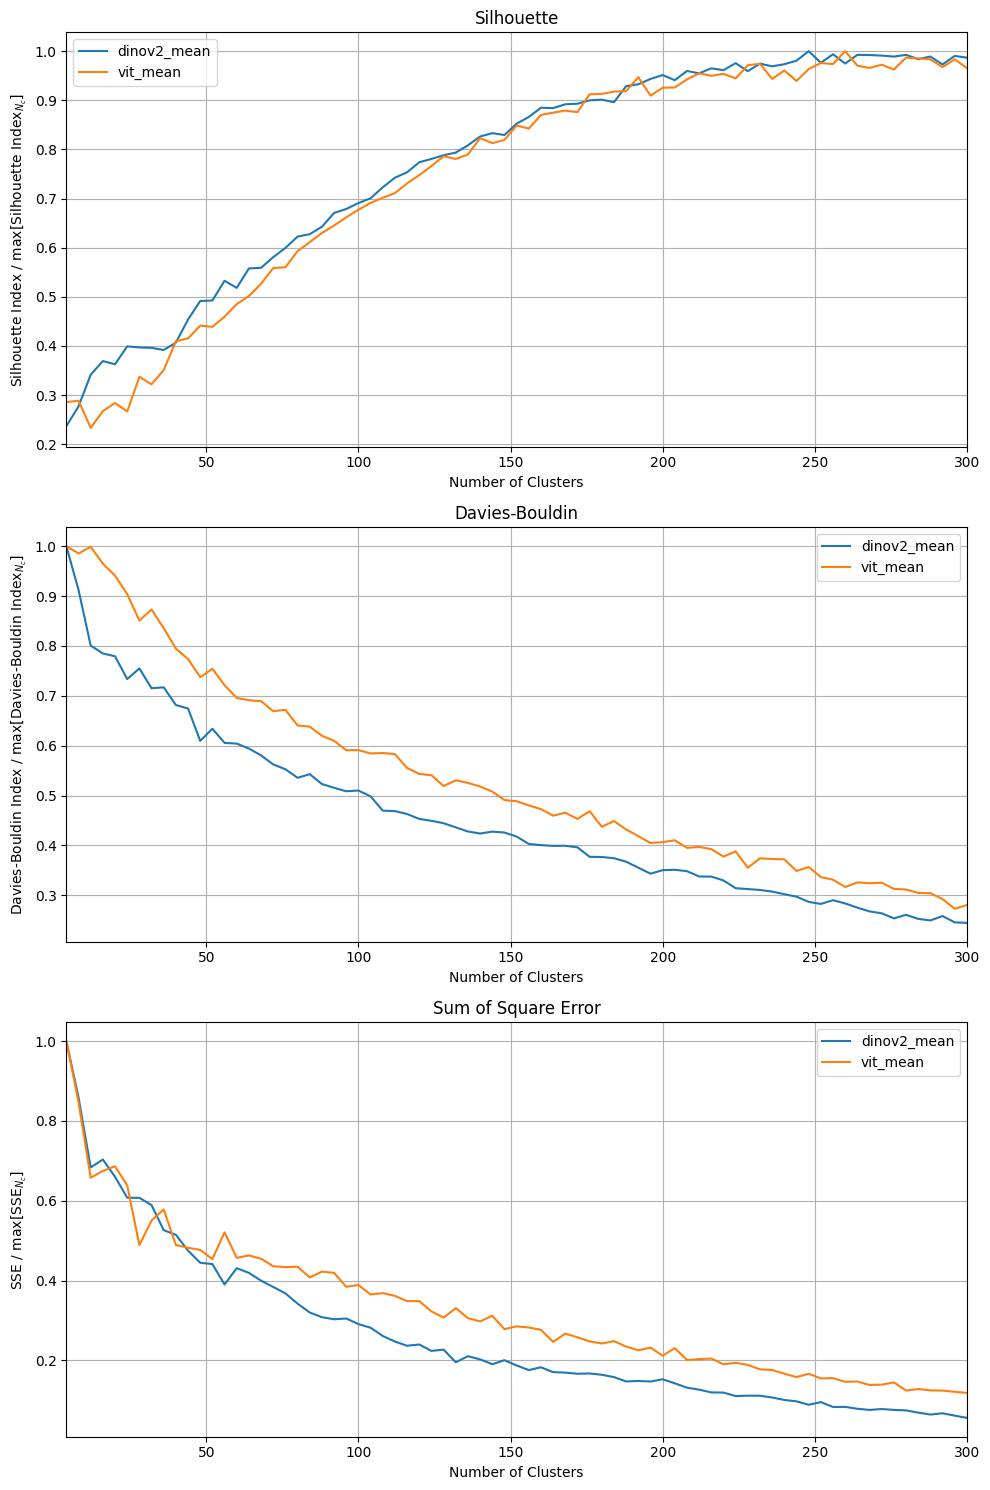

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.array(range(min_clusters, max_clusters + 1, 4))
y = [
    [
        dinov2_mean_ss_scores / np.max(dinov2_mean_ss_scores),
        vit_mean_ss_scores / np.max(vit_mean_ss_scores),
    ],
    [
        dinov2_mean_dbs_scores / np.max(dinov2_mean_dbs_scores),
        vit_mean_dbs_scores / np.max(vit_mean_dbs_scores),
    ],
    [
        dinov2_mean_sse_scores / np.max(dinov2_mean_sse_scores),
        vit_mean_sse_scores / np.max(vit_mean_sse_scores)
    ]
]

labels = [
    'dinov2_mean', 'vit_mean'
]

y_labels = [
    r"$\text{Silhouette Index / max}[\text{Silhouette Index}_{N_c}]$",
    r"$\text{Davies-Bouldin Index / max}[\text{Davies-Bouldin Index}_{N_c}]$",
    r"$\text{SSE / max}[\text{SSE}_{N_c}]$"
]

# Create a figure and a grid of subplots (3 rows, 1 column)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Titles for the subplots
titles = ['Silhouette', 'Davies-Bouldin', 'Sum of Square Error']

# Loop through each subplot
for i, (ax, title, y_label) in enumerate(zip(axes, titles, y_labels)):
    for y_i, label in zip(y[i], labels):
        ax.plot(x, y_i, label=label)
    ax.set_title(title)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel(y_label)
    ax.set_xlim(min_clusters, max_clusters)
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()